In [11]:
import pandas as pd
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import math
from rouge import Rouge
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
sns.set()

In [12]:
def show(x):
    print(x.shape)
    return x.head()

In [13]:
references = pd.read_csv("../data/references.csv").set_index("reference_id")
show(references)
references.head(20)

(24921, 3)


,title,original_citations,abstract
reference_id,,,
0,Distributed Representations of Words and Phras...,172,The recently introduced continuous Skip-gram m...
1,BERT: Pre-training of Deep Bidirectional Trans...,167,We introduce a new language representation mod...
2,Attention Is All You Need,155,The dominant sequence transduction models are ...
3,GloVe : Global Vectors for Word Representation,154,NaN
4,Adam: A Method for Stochastic Optimization,123,"We introduce Adam, an algorithm for first-orde..."
5,Long Short-Term Memory,98,NaN
6,Deep Contextualized Word Representations,96,We introduce a new type of deep contextualized...
7,Neural Machine Translation By Jointly Learning...,92,Neural machine translation is a recently propo...
8,Efficient Estimation of Word Representations i...,90,We propose two novel model architectures for c...


In [14]:
papers = pd.read_csv("../data/papers.csv").set_index("paper_id")
show(papers)

(1091, 3)


,title,abstract,text
paper_id,,,
0,IDST at TREC 2019 Deep Learning Track: Deep Ca...,This paper describes our participation in the ...,"KEYWORDS cascade ranking, pre-trained language..."
1,BatchBALD: Efficient and Diverse Batch Acquisi...,"We develop BatchBALD, a tractable approximatio...",A key problem in deep learning is data efficie...
2,A Sentence Compression Based Framework to Quer...,We consider the problem of using sentence comp...,Proceedings of the 51st Annual Meeting of the ...
3,DR-BiLSTM: Dependent Reading Bidirectional LST...,We present a novel deep learning architecture ...,Natural Language Inference (NLI; a.k.a. Recogn...
4,On Minimizing Cost in Legal Document ReviewWor...,Technology-assisted review (TAR) refers to hum...,CCS CONCEPTS • Information systems → Informati...


In [15]:
citations = pd.read_csv("../data/citations.csv")
show(citations)

(56746, 6)


,paper_id,internal_reference_id,reference_id,context,start_offset,end_offset
0,0,1,1,Our approach is mainly based on the BERT langu...,56,59
1,0,8,444,Different from many other ranking methods whic...,216,219
2,0,5,163,"Moreover, for full ranking subtask, we use a s...",78,81
3,0,6,26,The proposed model is based on the pointer-gen...,59,62
4,0,6,26,"Following [7], we also use a soft switch to ch...",10,13


In [16]:
citations.context[1]

'Different from many other ranking methods which directly finetune the original BERT model in downstream task, we modify the next sentence prediction task in BERT to a 3-class sentence classification as in StructBERT [9] and pre-train a new BERT language model from scratch.'

In [17]:
citations.groupby(["paper_id", "reference_id"]).size()

paper_id  reference_id
0         1               2
          2               1
          13              1
          20              1
          26              3
                         ..
1090      15196           1
          19556           1
          21554           1
          22512           1
          24876           1
Length: 33124, dtype: int64

# rouge against original abstract

In [18]:
retrieved = citations.groupby(["paper_id", "reference_id"]).context.sum().reset_index()
show(retrieved)

(33124, 3)


,paper_id,reference_id,context
0,0,1,Our approach is mainly based on the BERT langu...
1,0,2,BERT [2] is a self-supervised approach for pre...
2,0,13,"Recently, some variants [4, 12] of BERT langua..."
3,0,20,"Recently, some variants [4, 12] of BERT langua..."
4,0,26,The proposed model is based on the pointer-gen...


In [19]:
retrieved.iloc[1].context

'BERT [2] is a self-supervised approach for pre-training a deep transformer encoder [8], before fine-tuning it for a particular downstream task.'

In [20]:
queries = retrieved.merge(references.drop(columns = "title"), on = "reference_id")\
.rename(columns = {"abstract":"reference", "context":"hypothesis", "text":"paper_text"})\
.dropna()\
.reset_index(drop = True)
show(queries)

(10790, 5)


,paper_id,reference_id,hypothesis,original_citations,reference
0,0,1,Our approach is mainly based on the BERT langu...,167,We introduce a new language representation mod...
1,7,1,"BERT (Devlin et al., 2019) and its improvement...",167,We introduce a new language representation mod...
2,8,1,performed by pretrained language models (LMs) ...,167,We introduce a new language representation mod...
3,12,1,[118] proposed a new language representation m...,167,We introduce a new language representation mod...
4,17,1,"In particular, Bidirectional Encoder Represent...",167,We introduce a new language representation mod...


In [21]:
rouge = Rouge()
scores = rouge.get_scores(hyps = queries.hypothesis, refs = queries.reference)
print(len(scores))
scores[:5]

10790


[{'rouge-1': {'r': 0.11607142857142858,
   'p': 0.3939393939393939,
   'f': 0.17931034131177173},
  'rouge-2': {'r': 0.014084507042253521,
   'p': 0.04878048780487805,
   'f': 0.021857920020305732},
  'rouge-l': {'r': 0.10714285714285714,
   'p': 0.36363636363636365,
   'f': 0.1655172378634959}},
 {'rouge-1': {'r': 0.13392857142857142,
   'p': 0.22058823529411764,
   'f': 0.16666666196543226},
  'rouge-2': {'r': 0.007042253521126761,
   'p': 0.012345679012345678,
   'f': 0.008968605239601008},
  'rouge-l': {'r': 0.13392857142857142,
   'p': 0.22058823529411764,
   'f': 0.16666666196543226}},
 {'rouge-1': {'r': 0.16964285714285715,
   'p': 0.2159090909090909,
   'f': 0.18999999507200013},
  'rouge-2': {'r': 0.007042253521126761,
   'p': 0.008547008547008548,
   'f': 0.00772200276859637},
  'rouge-l': {'r': 0.16071428571428573,
   'p': 0.20454545454545456,
   'f': 0.17999999507200018}},
 {'rouge-1': {'r': 0.24107142857142858,
   'p': 0.39705882352941174,
   'f': 0.2999999952987655},
  'r

In [22]:
rouge_df = pd.DataFrame.from_records(scores)
show(rouge_df)

(10790, 3)


,rouge-1,rouge-2,rouge-l
0,"{'r': 0.11607142857142858, 'p': 0.393939393939...","{'r': 0.014084507042253521, 'p': 0.04878048780...","{'r': 0.10714285714285714, 'p': 0.363636363636..."
1,"{'r': 0.13392857142857142, 'p': 0.220588235294...","{'r': 0.007042253521126761, 'p': 0.01234567901...","{'r': 0.13392857142857142, 'p': 0.220588235294..."
2,"{'r': 0.16964285714285715, 'p': 0.215909090909...","{'r': 0.007042253521126761, 'p': 0.00854700854...","{'r': 0.16071428571428573, 'p': 0.204545454545..."
3,"{'r': 0.24107142857142858, 'p': 0.397058823529...","{'r': 0.1267605633802817, 'p': 0.24, 'f': 0.16...","{'r': 0.23214285714285715, 'p': 0.382352941176..."
4,"{'r': 0.24107142857142858, 'p': 0.333333333333...","{'r': 0.07042253521126761, 'p': 0.104166666666...","{'r': 0.24107142857142858, 'p': 0.333333333333..."


In [23]:
rouge_1 = pd.DataFrame.from_records(rouge_df["rouge-1"])\
.rename(columns = {"f":"rouge_1_f", "r":"rouge_1_r", "p":"rouge_1_p"})
show(rouge_1)

(10790, 3)


,rouge_1_r,rouge_1_p,rouge_1_f
0,0.116071,0.393939,0.179310
1,0.133929,0.220588,0.166667
2,0.169643,0.215909,0.190000
3,0.241071,0.397059,0.300000
4,0.241071,0.333333,0.279793


In [24]:
rouge_2 = pd.DataFrame.from_records(rouge_df["rouge-2"])\
.rename(columns = {"f":"rouge_2_f", "r":"rouge_2_r", "p":"rouge_2_p"})
show(rouge_2)

(10790, 3)


,rouge_2_r,rouge_2_p,rouge_2_f
0,0.014085,0.048780,0.021858
1,0.007042,0.012346,0.008969
2,0.007042,0.008547,0.007722
3,0.126761,0.240000,0.165899
4,0.070423,0.104167,0.084034


In [25]:
rouge_l = pd.DataFrame.from_records(rouge_df["rouge-l"])\
.rename(columns = {"f":"rouge_l_f", "r":"rouge_l_r", "p":"rouge_l_p"})
show(rouge_l)

(10790, 3)


,rouge_l_r,rouge_l_p,rouge_l_f
0,0.107143,0.363636,0.165517
1,0.133929,0.220588,0.166667
2,0.160714,0.204545,0.180000
3,0.232143,0.382353,0.288889
4,0.241071,0.333333,0.279793


In [26]:
full_rouge = pd.concat((queries, rouge_1, rouge_2, rouge_l), axis = 1)
show(full_rouge)

(10790, 14)


,paper_id,reference_id,hypothesis,original_citations,reference,rouge_1_r,rouge_1_p,rouge_1_f,rouge_2_r,rouge_2_p,rouge_2_f,rouge_l_r,rouge_l_p,rouge_l_f
0,0,1,Our approach is mainly based on the BERT langu...,167,We introduce a new language representation mod...,0.116071,0.393939,0.179310,0.014085,0.048780,0.021858,0.107143,0.363636,0.165517
1,7,1,"BERT (Devlin et al., 2019) and its improvement...",167,We introduce a new language representation mod...,0.133929,0.220588,0.166667,0.007042,0.012346,0.008969,0.133929,0.220588,0.166667
2,8,1,performed by pretrained language models (LMs) ...,167,We introduce a new language representation mod...,0.169643,0.215909,0.190000,0.007042,0.008547,0.007722,0.160714,0.204545,0.180000
3,12,1,[118] proposed a new language representation m...,167,We introduce a new language representation mod...,0.241071,0.397059,0.300000,0.126761,0.240000,0.165899,0.232143,0.382353,0.288889
4,17,1,"In particular, Bidirectional Encoder Represent...",167,We introduce a new language representation mod...,0.241071,0.333333,0.279793,0.070423,0.104167,0.084034,0.241071,0.333333,0.279793


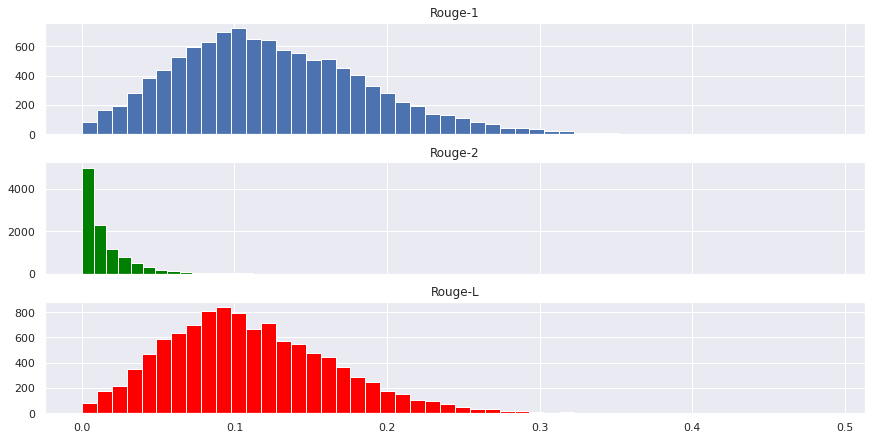

In [27]:
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].hist(full_rouge.rouge_1_f, bins = 50)
ax[0].set_title("Rouge-1")
ax[1].hist(full_rouge.rouge_2_f, bins = 50, color = "green")
ax[1].set_title("Rouge-2")
ax[2].hist(full_rouge.rouge_l_f, bins = 50, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

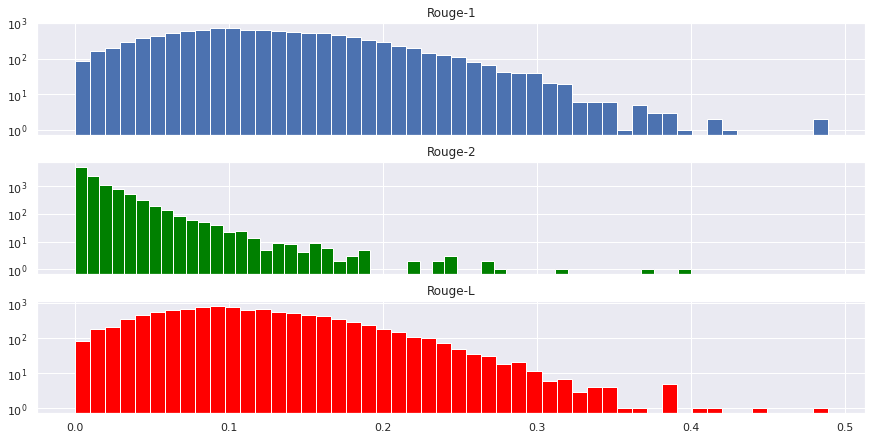

In [28]:
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].hist(full_rouge.rouge_1_f, bins = 50, log = True)
ax[0].set_title("Rouge-1")
ax[1].hist(full_rouge.rouge_2_f, bins = 50, color = "green", log = True)
ax[1].set_title("Rouge-2")
ax[2].hist(full_rouge.rouge_l_f, bins = 50, color = "red", log = True)
ax[2].set_title("Rouge-L")

plt.show()

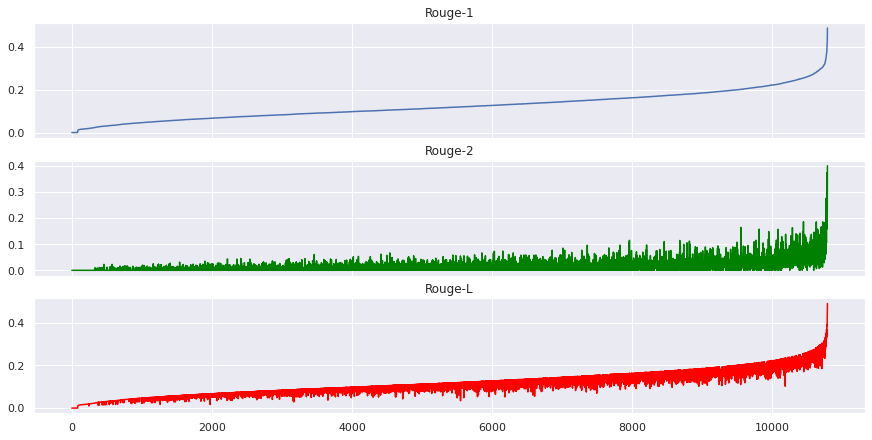

In [29]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1")
ax[1].plot(data.rouge_2_f, color = "green")
ax[1].set_title("Rouge-2")
ax[2].plot(data.rouge_l_f, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

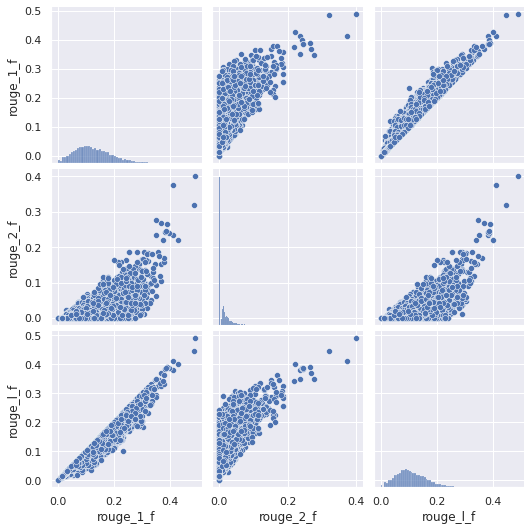

In [30]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_2_f", "rouge_l_f"])
plt.show()

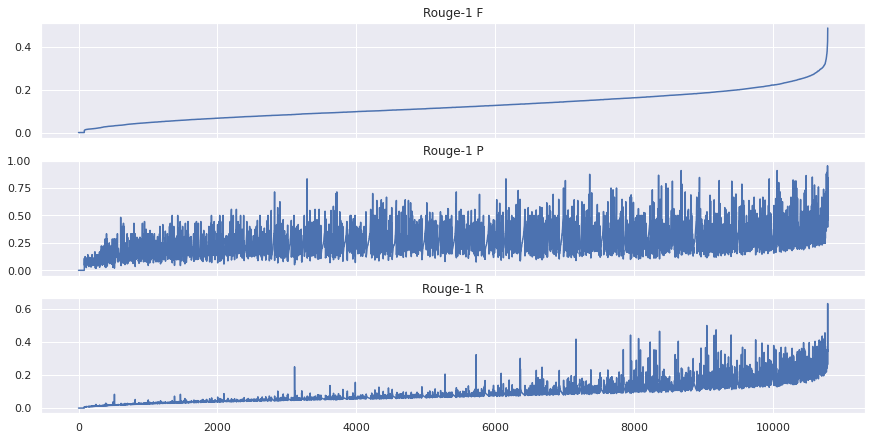

In [31]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1 F")
ax[1].plot(data.rouge_1_p)
ax[1].set_title("Rouge-1 P")
ax[2].plot(data.rouge_1_r)
ax[2].set_title("Rouge-1 R")

plt.show()

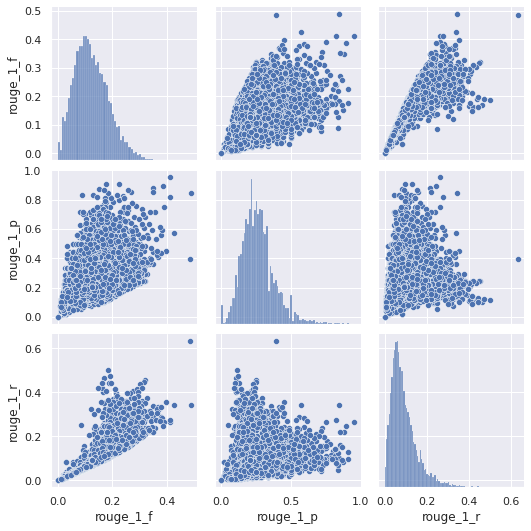

In [32]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_1_p", "rouge_1_r"])
plt.show()

# worst

In [33]:
for d in full_rouge.sort_values("rouge_1_f").head().to_dict("records"):
    print("paper_id:", d["paper_id"], ", reference_id:", d["reference_id"])
    print("rouge 1 f:", d["rouge_1_f"])
    print()
    print(d["hypothesis"])
    print()
    print(d["reference"])
    print("*"*30)

paper_id: 802 , reference_id: 1252
rouge 1 f: 0.0

0M 1024D pretrained GRU encoders (Vendrov et al., 2015) 98.

Hypernymy, textual entailment, and image captioning can be seen as special cases of a single visual-semantic hierarchy over words, sentences, and images. In this paper we advocate for explicitly modeling the partial order structure of this hierarchy. Towards this goal, we introduce a general method for learning ordered representations, and show how it can be applied to a variety of tasks involving images and language. We show that the resulting representations improve performance over current approaches for hypernym prediction and image-caption retrieval.
******************************
paper_id: 595 , reference_id: 1683
rouge 1 f: 0.0

data processing (1,175) sentence-level (sentence embedding) (25) [325], [326], [327]

We consider the problem of learning general-purpose, paraphrastic sentence embeddings, revisiting the setting of Wieting et al. (2016b). While they found LSTM

# best

In [34]:
for d in full_rouge.sort_values("rouge_1_f", ascending = False).head().to_dict("records"):
    print("paper_id:", d["paper_id"], ", reference_id:", d["reference_id"])
    print("rouge 1 f:", d["rouge_1_f"])
    print()
    print(d["hypothesis"])
    print()
    print(d["reference"])
    print("*"*100)

paper_id: 12 , reference_id: 14480
rouge 1 f: 0.48888888478024695

Zhang and Yang [149] proposed a lattice-structured LSTM model for Chinese NER, which encodes a sequence of input characters as well as all potential words that match a lexicon.

We investigate a lattice-structured LSTM model for Chinese NER, which encodes a sequence of input characters as well as all potential words that match a lexicon. Compared with character-based methods, our model explicitly leverages word and word sequence information. Compared with word-based methods, lattice LSTM does not suffer from segmentation errors. Gated recurrent cells allow our model to choose the most relevant characters and words from a sentence for better NER results. Experiments on various datasets show that lattice LSTM outperforms both word-based and character-based LSTM baselines, achieving the best results.
****************************************************************************************************
paper_id: 145 , referen

In [35]:
full_rouge[["rouge_1_f", "rouge_2_f", "rouge_l_f"]].describe(percentiles = np.linspace(0, 1, 11))

,rouge_1_f,rouge_2_f,rouge_l_f
count,10790.000000,10790.000000,10790.000000
mean,0.124491,0.014862,0.111148
std,0.062941,0.022810,0.055883
min,0.000000,0.000000,0.000000
0%,0.000000,0.000000,0.000000
10%,0.048387,0.000000,0.044776
20%,0.069930,0.000000,0.063158
30%,0.086957,0.000000,0.078652
40%,0.101695,0.000000,0.091405
50%,0.117647,0.009434,0.104348
